In [38]:
#!pip install torch

     -------------------------------------- 158.0/158.0 MB 5.8 MB/s eta 0:00:00


In [40]:
#!pip install torchvision

     ---------------------------------------- 1.0/1.0 MB 5.9 MB/s eta 0:00:00


In [33]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow
# import tensorflow.keras
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# from tensorflow.keras.preprocessing import image
# from PIL import Image
# #import cv2
# import matplotlib.cm as cm
# import os

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform

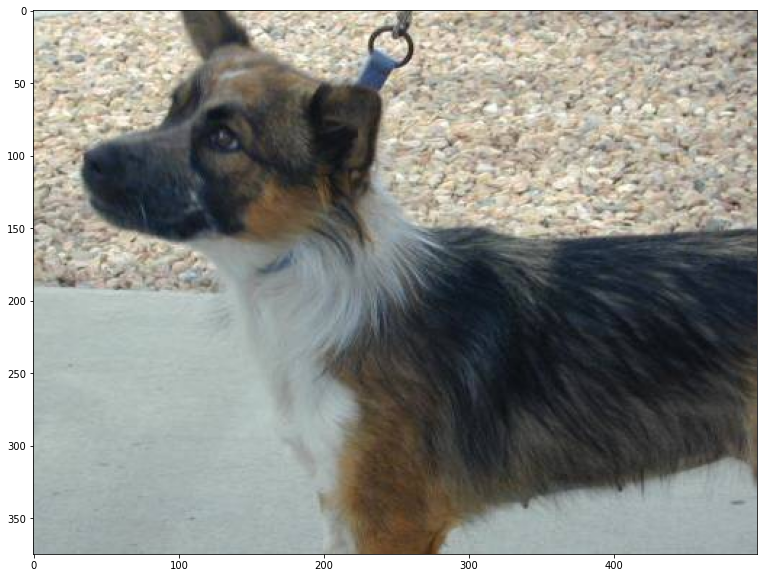

In [2]:
img_path = "data/archive/dataset/training_set/dogs/dog.3.jpg"

image = Image.open(img_path)
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

In [3]:
# Imagenet mean/std
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Scale to 224x224, convert to tensor, and normalize with mean/std for ImageNet
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize,
])

x_img = preprocess(image).unsqueeze(0)

In [4]:
model = models.resnet18(pretrained=True)

In [5]:
# Get the features from a model
class SaveFeatures():
    features = None
    def __init__(self, module): 
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): 
        self.features = output.data.numpy()

    def remove(self): 
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [6]:
# Get features from last conv layer
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

# Inference
_ = model.eval()
prediction = model(x_img)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
print('Top-1 prediction:', torch.topk(pred_probabilities, 1))

# Take weights from the first linear layer
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

# Get the top-1 prediction and get CAM
class_idx = torch.topk(pred_probabilities, 1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

Top-1 prediction: torch.return_types.topk(
values=tensor([0.1962]),
indices=tensor([193]))


<ipython-input-6-b0d15d6eb84f>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


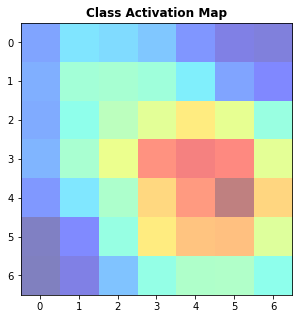

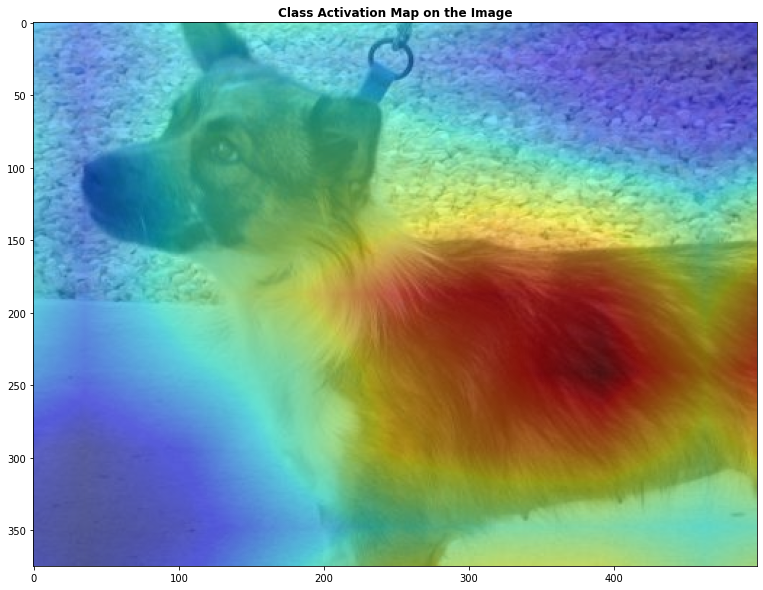

In [7]:
# Show CAM
plt.figure(figsize=(5, 5))
plt.title('Class Activation Map', fontweight='bold')
plt.imshow(overlay[0], alpha=0.5, cmap='jet')

# Show CAM on the image
plt.figure(figsize=(15, 10))
plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(skimage.transform.resize(overlay[0], (image.size[1], image.size[0])), alpha=0.5, cmap='jet');
plt.show()